In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.cm as cm
from PIL import Image
from tensorflow import keras
from keras import backend as K
from keras import layers, Model
import matplotlib.pyplot as plt
from keras.src.optimizers import Adam
from keras.src.layers import Conv2D, SeparableConv2D, MaxPooling2D, GlobalMaxPooling2D,\
     BatchNormalization, Dropout, SpatialDropout2D,\
     Input, Flatten, Dense, Activation
from keras.src.utils import image_dataset_from_directory
from keras.src.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import ParameterGrid
# from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, GlobalMaxPooling2D,\
#      AveragePooling2D, BatchNormalization, GlobalAveragePooling2D, Dropout, SpatialDropout2D,\
#      Input, Flatten, Dense, Activation
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.utils import image_dataset_from_directory

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def plot_metric(history, metric='loss'):
    """ Plot training and test values for a metric. """

    val_metric = 'val_'+metric
    plt.plot(history.history[metric])
    plt.plot(history.history[val_metric])
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show()

In [4]:
# the following code was taken from the keras documentation : https://keras.io/api/data_loading/image/
data_dir = "/content/drive/MyDrive/Colab Notebooks/chest_xray_multiclass"

train_dir = data_dir + "/train"
test_dir = data_dir + "/test"

training_data = image_dataset_from_directory(
    train_dir,
    labels='inferred', # the labels are inferred
    label_mode='int',
    batch_size=32,
    image_size=(224,224)
    )

test_data = image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224,224)
    )

Found 5232 files belonging to 3 classes.
Found 624 files belonging to 3 classes.


In [18]:
# Function to extract features (X) and labels (y) from a dataset
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for image_batch, label_batch in dataset:
        images.append(image_batch.numpy())  # Convert image tensors to NumPy arrays
        print(f"images with labels {label_batch} appended") # printing the process for the sake of sanity
        labels.append(label_batch.numpy())  # Convert label tensors to NumPy arrays
    return np.concatenate(images), np.concatenate(labels)

# Extract training data
X_train, y_train = dataset_to_numpy(training_data)

# Extract test data
X_test, y_test = dataset_to_numpy(test_data)


images with labels [1 2 0 1 0 0 2 1 1 1 0 1 0 2 1 2 0 0 2 0 1 1 1 1 2 0 2 2 1 0 1 1] appended
images with labels [0 1 2 1 0 0 0 1 1 2 2 2 1 2 1 2 1 0 1 2 2 0 1 0 1 0 2 1 1 0 0 1] appended
images with labels [1 1 1 1 2 0 2 0 1 1 1 1 1 0 0 2 1 0 0 1 2 0 0 0 2 1 1 1 2 0 2 2] appended
images with labels [0 2 1 1 1 0 2 1 1 1 1 0 0 1 2 1 1 2 1 1 1 0 0 0 1 1 0 0 2 0 1 2] appended
images with labels [2 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 2 0 2 1 0 1 2 0 0 1 2 1 2 1] appended
images with labels [1 2 1 1 2 1 0 0 2 0 1 0 0 1 0 2 1 1 1 2 2 1 2 1 1 1 1 2 0 0 2 2] appended
images with labels [2 1 0 1 1 1 0 0 2 0 1 2 1 2 2 0 0 1 2 1 0 1 0 0 1 0 1 1 0 1 0 1] appended
images with labels [2 0 0 1 2 0 2 0 1 0 0 0 1 1 2 2 2 0 1 1 0 1 1 0 1 1 0 1 1 1 2 1] appended
images with labels [0 2 0 1 1 0 2 0 1 0 1 2 1 1 1 1 1 0 1 1 1 1 1 0 1 2 1 1 0 2 1 1] appended
images with labels [1 2 0 0 2 2 0 1 1 1 0 2 2 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 2 1 2 0] appended
images with labels [2 0 1 1 1 1 1 1 0 2 1 1 1 2 1 1 1 0 0 0 

Below is a few sanity checks for our data and our last touch of preprocessing

In [ ]:
print(X_train.shape)
print(y_train.shape)

(5232, 224, 224, 3)
(5232,)


In [ ]:
print(X_test.shape)
print(y_test.shape)

(624, 224, 224, 3)
(624,)


In [ ]:
print(X_train.min(), X_train.max())
print(np.unique(y_train))

0.0 255.0
[0 1 2]


In [ ]:
# preprocessing
# from integers in [0,255] to float in [0,1]
print('processing training data...')
X_train = X_train.astype('float16') / 255.0

processing training data...


In [ ]:
print('processing test data...')
X_test  = X_test.astype('float16') / 255.0

processing test data...


In [ ]:
print(X_train.min(), X_train.max())

0.0 1.0


In [ ]:
num_classes = len(np.unique(y_train))

# **Baseline Model**

In [ ]:
model = keras.models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape= X_train.shape[1:], name = "firstConvLayer"))
model.add(layers.MaxPooling2D((2,2), name = "firstMaxPoolLayer"))
model.add(layers.Dropout(0.5, name = "firstDropoutLayer"))
model.add(layers.Conv2D(64, (3, 3), activation='relu', name = "secondConvLayer"))
model.add(layers.MaxPooling2D((2,2), name = "secondMaxPoolLayer"))
model.add(layers.Dropout(0.5, name = "secondDropoutLayer"))
model.add(layers.Flatten(name = "flatteningLayer"))
model.add(layers.Dense(64, activation='relu', name = "firstDenseLayer"))
# output layer
model.add(layers.Dense(3, activation='softmax', name = "predictionLayer"))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ firstConvLayer (Conv2D)              │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ firstMaxPoolLayer (MaxPooling2D)     │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ firstDropoutLayer (Dropout)          │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ secondConvLayer (Conv2D)             │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ secondMaxPoolLayer (MaxPooling2D)    │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ secondDropoutLayer (Dropout)         │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatteningLayer (Flatten)            │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ firstDenseLayer (Dense)              │ (None, 64)                  │      11,944,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictionLayer (Dense)              │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,963,587 (45.64 MB)

 Trainable params: 11,963,587 (45.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
              )
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split = 0.3, callbacks = [EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 32s 377ms/step - accuracy: 0.4733 - loss: 3.7333 - val_accuracy: 0.5057 - val_loss: 0.9472
Epoch 2/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.6069 - loss: 0.9005 - val_accuracy: 0.6809 - val_loss: 0.7792
Epoch 3/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.7207 - loss: 0.6449 - val_accuracy: 0.7503 - val_loss: 0.5838
Epoch 4/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.7682 - loss: 0.5298 - val_accuracy: 0.7720 - val_loss: 0.5811
Epoch 5/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.7924 - loss: 0.4763 - val_accuracy: 0.7707 - val_loss: 0.5716


# **Grad-CAM for Visualizing the Decisions Made by Our Model**

This notebook follows the technique shared by Francois Chollet in the book 'Deep Learning with Python, Second Edition'.

Grad-CAM is a technique that is useful for understanding which parts of a given image led a convnet to its final classification decision. This is helpful for “debugging” the decision process of a convnet, particularly in the case of a classification mistake (a problem domain called model interpretability).

It creates a class activation heatmap which shows how important each input location is with respect to the class under consideration.

In [ ]:
def make_activation_heatmap(model, img_array ,label,  last_conv_layer_name, classifier_layer_names):

  ''' We get an image array (already preprocessed) and generate a heatmap for it showing which parts where considered by the
  model while making its decision '''


  #making prediction on the model to see what the decision is
  pred = model.predict(img_array)
  print(f"Model's prediction : {np.argmax(pred)}")
  print(f"Actual label : {label}")

  #dividing the model into two parts - feature extraction model and classifier model
  last_conv_layer = model.get_layer(last_conv_layer_name)
  last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output) # feature extraction model

  classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
  x = classifier_input
  for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
  classifier_model = keras.Model(classifier_input, x) # feature extraction model

  #Then we compute the gradient of the top predicted class for our input image with respect to the activations of the last convolution layer.
  with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array) # output of last conv layer
    tape.watch(last_conv_layer_output) # compute gradients
    preds = classifier_model(last_conv_layer_output) # output of the classification w.r.t. last conv layer
    top_pred_index = tf.argmax(preds[0]) # index of highest prediction class to identify which class to focus upon
    top_class_channel = preds[:, top_pred_index]  # extract the score corresponding to the top predicted class across the batch.

  grads = tape.gradient(top_class_channel, last_conv_layer_output) # Computes the gradient of the top_class_channel (target class score) with respect to the last_conv_layer_output (feature maps).

  #Now we apply pooling and importance weighting to the gradient tensor to obtain our heatmap of class activation.
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
  last_conv_layer_output = last_conv_layer_output.numpy()[0]
  for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
  heatmap = np.mean(last_conv_layer_output, axis=-1)

  # making a standalone class activation heatmap
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  plt.matshow(heatmap)

  #Superimposing the heatmap on the original picture
  img = np.squeeze(img_array, axis=0)

  heatmap = np.uint8(255 * heatmap)

  jet = cm.get_cmap("jet")
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  jet_heatmap = keras.utils.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.utils.img_to_array(jet_heatmap)

  superimposed_img = jet_heatmap * 0.4 + img
  superimposed_img = keras.utils.array_to_img(superimposed_img)

  save_path = "pneumonia.jpg"
  superimposed_img.save(save_path)

  # Load the saved image
  saved_image_path = "pneumonia.jpg"
  image = Image.open(saved_image_path)

  # Display the image
  plt.imshow(image)
  plt.show()

In [ ]:
# using an image from the test dataset to visualize the decision of the model
img = X_test[4] # this is already pre-processed which is convenient
img = np.expand_dims(img, axis=0) # adding the batch dimension
print(img.shape)

(1, 224, 224, 3)


Now we will see which part of the image led to the model's decision.

First, we create a model that maps the input image to the activations of the last convolutional layer. Reason being that we want to see what parts of the image lead to the final prediction. And the last convolutional layer contains the most informative features of an image.

The last conv layer will be used to build a submodel (last_conv_layer_model) that outputs the feature maps at this layer.
These feature maps are critical for visualizing what the model "sees" in the input image.

Second, we create a model that maps the activations of the last convolutional layer to the final class predictions.

Then we compute the gradient of the top predicted class for our input image with respect to the activations of the last convolution layer.

Grad-CAM requires the gradient of the target class score with respect to the feature maps from the last convolutional layer.

In [ ]:
last_conv_layer_name = 'secondConvLayer' # the last feature extracting layer
classifier_layers_names = [ # layers that classify the extracted features - they come after the last convolutional layer
    "secondMaxPoolLayer",
     "flatteningLayer",
    "firstDenseLayer",
    "predictionLayer"
]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Model's prediction : 2
Actual label : 2


<ipython-input-16-c35c61133817>:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


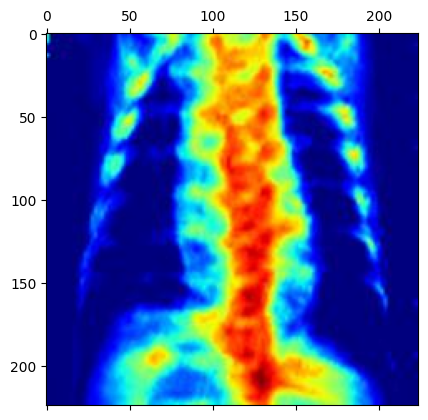

In [ ]:
make_activation_heatmap(model, img, y_test[4], last_conv_layer_name, classifier_layers_names )

# **Hyperparameter Tuning**

Now we tune the hyperparameters to achieve a better accuracy

In [ ]:
def get_model(input_shape, output_size, *,
              dropout=0.5, act_fun='elu',
              conv_layers=[32, 64, 128], padding='same', dense_layers=[64],
              conv_size=3, pool_size=2,
              stride=2,
              ):

    inputs = Input(input_shape)
    x = inputs

    for num_filters in conv_layers:
            residual = x

            x = Activation(act_fun)(x)
            x = BatchNormalization()(x)

            x = SeparableConv2D(num_filters, conv_size, padding=padding, strides=stride,)(x)
            x = SeparableConv2D(num_filters, conv_size, padding=padding,)(x)

            residual = SeparableConv2D(num_filters, 1, padding=padding, strides=stride,)(residual)
            x = layers.add([x, residual])

            x = MaxPooling2D(pool_size, strides=stride)(x)

            x = SpatialDropout2D(dropout)(x)

    for num_filters in conv_layers:

        residual = x

        x = Activation(act_fun)(x)
        x = BatchNormalization()(x)


        x = Conv2D(num_filters, conv_size, padding=padding, strides=stride)(x)
        x = Conv2D(num_filters, conv_size, padding=padding)(x)

        residual = Conv2D(num_filters, 1, padding=padding, strides=stride)(residual)
        x = layers.add([x, residual])

        x = MaxPooling2D(pool_size)(x)

        x = SpatialDropout2D(dropout)(x)

    x = Flatten()(x)

    for dense_size in dense_layers:

        x = Activation(act_fun)(x)
        x = BatchNormalization()(x)
        x = Dense(dense_size)(x)
        x = Dropout(dropout)(x)

    outputs = Dense(output_size, activation='softmax')(x)

    return Model(inputs, outputs)

More training is necessary to determine how the model is learning, however, the baseline is achieved with the highest validation accuracy being 79.17

In [ ]:
default_params = {
    'dropout': 0.5,
    'act_fun': 'elu',
    'num_filters': [32, 64, 128],
    'hidden_dims': [64],
    'filter_size': 3,
    'pool_size': 2,
    'stride': 1,
    'batch_size':[32],
    }

In [ ]:
def evaluate_params(params, verbose=1):
    """ Return validation accuracy for a model built and trained using the given parameters.
    args:
        params: a Python dictionary
    """

    # default parameters are used if not supplied
    pars = default_params.copy()
    pars.update(params)

    num_filters = pars['num_filters']
    filter_size = pars['filter_size']
    pool_size = pars['pool_size']
    batch_size = pars['batch_size']
    dropout = pars['dropout']
    stride = pars['stride']
    dense_layers = pars['hidden_dims']
    act_fun = pars['act_fun']


    model = get_model(X_train.shape[1:], num_classes, act_fun = act_fun, conv_layers=num_filters,
                      conv_size=filter_size, dropout=dropout,
                      dense_layers=dense_layers, pool_size=pool_size,
                      stride=stride,)
    model.compile(optimizer=Adam(learning_rate=0.002),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    history = model.fit(X_train, y_train, epochs=20, callbacks=[EarlyStopping(patience=5, verbose=verbose, restore_best_weights=True), ReduceLROnPlateau(patience=3, factor=0.5, verbose=verbose)], batch_size=batch_size,
                        validation_split=0.3, verbose=verbose)
    mean_acc = np.mean(history.history['val_accuracy'][-2:])

    return pars, mean_acc, history

In [ ]:
def random_search(param_grid, num_tests=5, random_state=None, verbose=1):
    """ Randomly (without replacement) evaluate parameter combinations of param_grid.

    args:
        param_grid  a ParameterGrid
        num_tests   maximum number of parameter combinations to try.  If there
                    are fewer than num_tests combinations in param_grid, use only
                    the number of combinations available
        random_state
    """

    if random_state is not None:
        np.random.seed(random_state)

    # create a list of unique parameter combinations
    param_combs = list(ParameterGrid(param_grid))
    if len(param_combs) < num_tests:
        num_tests = len(param_combs)
    random_combs = np.random.choice(param_combs, size=num_tests, replace=False)

    # evaluate each of the combinations
    params_list = []
    acc_list = []
    for params in random_combs:
        K.clear_session()

        print(f"params: {params}")
        pars, acc, history = evaluate_params(params, verbose=verbose)

        plot_metric(history)

        params_list.append(pars)
        acc_list.append(acc)

    return params_list, acc_list

In [ ]:
def scores_to_dataframe(scores):
    """ Return hyperparameters and scores in a data frame. """

    params_list, acc_list = scores

    params = pd.DataFrame(params_list)
    accs = pd.Series(acc_list)
    scores_df = pd.concat([params, accs], axis=1)

    return scores_df

In [20]:
K.clear_session()

In [ ]:
param_grid = {
    'act_fun' : ['relu', 'elu'],
    'filter_size': [5],
    'stride': [2],
    'num_filters': [[32, 64]],
    'batch_size': [32],
}

params: {'act_fun': 'elu', 'batch_size': 32, 'filter_size': 5, 'num_filters': [32, 64], 'stride': 2}
Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 40s 175ms/step - accuracy: 0.3569 - loss: 1.6453 - val_accuracy: 0.5013 - val_loss: 1.0077 - learning_rate: 0.0020
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.4655 - loss: 1.1292 - val_accuracy: 0.6656 - val_loss: 0.8639 - learning_rate: 0.0020
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.5970 - loss: 0.8986 - val_accuracy: 0.6382 - val_loss: 0.7617 - learning_rate: 0.0020
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.6580 - loss: 0.7728 - val_accuracy: 0.7115 - val_loss: 0.6127 - learning_rate: 0.0020
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.6827 - loss: 0.7111 - val_accuracy: 0.6879 - val_loss: 0.6440 - learning_rate: 0.0020
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.6881 - loss: 0.6571 - val_accuracy: 0.7159 - val_loss: 0.5644 

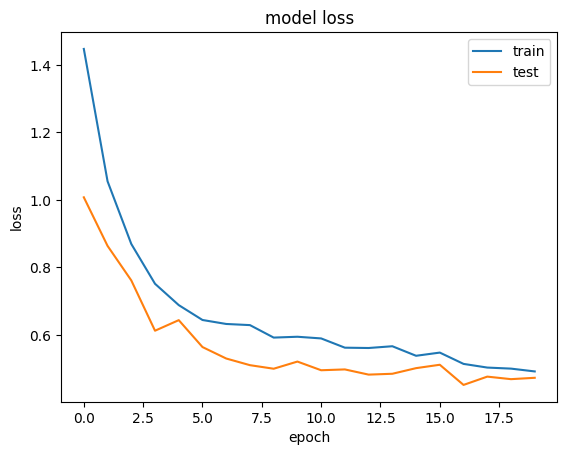

params: {'act_fun': 'relu', 'batch_size': 32, 'filter_size': 5, 'num_filters': [32, 64], 'stride': 2}
Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - accuracy: 0.3348 - loss: 1.6948 - val_accuracy: 0.5013 - val_loss: 1.0426 - learning_rate: 0.0020
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.4219 - loss: 1.1885 - val_accuracy: 0.5013 - val_loss: 1.0464 - learning_rate: 0.0020
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4315 - loss: 1.1262 - val_accuracy: 0.5013 - val_loss: 1.0215 - learning_rate: 0.0020
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.4420 - loss: 1.0925 - val_accuracy: 0.5911 - val_loss: 0.9754 - learning_rate: 0.0020
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4889 - loss: 1.0224 - val_accuracy: 0.6567 - val_loss: 0.8438 - learning_rate: 0.0020
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.5628 - loss: 0.9160 - val_accuracy: 0.6758 - val_loss: 0.7407 -

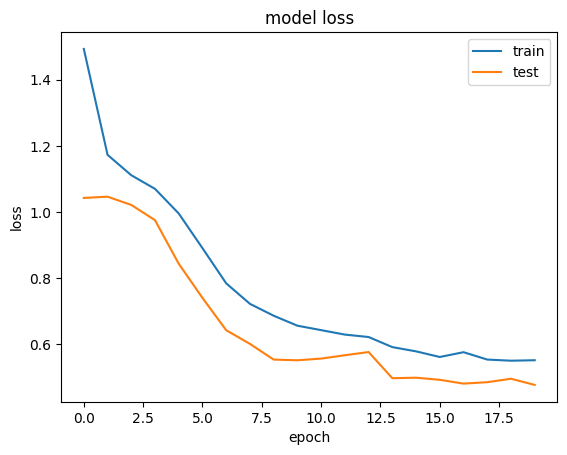

In [ ]:
results = random_search(param_grid, num_tests=5, random_state=42, verbose=1)

In [ ]:
scores_df = scores_to_dataframe(results)

# Rename the last column to 'accuracy'
scores_df.columns = list(scores_df.columns[:-1]) + ['accuracy']

print(scores_df)

   dropout act_fun num_filters hidden_dims  filter_size  pool_size  stride  \
0      0.5     elu    [32, 64]        [64]            5          2       2   
1      0.5    relu    [32, 64]        [64]            5          2       2   

   batch_size  accuracy  
0          32  0.785350  
1          32  0.782803  


As we can see the following hyperparameters give the best validation accuracy, so we need to re train another model on these

In [ ]:
# getting the best accuracy parametyrs to re-train our best model
num_filters = [32, 64]
filter_size = 5
pool_size = 2
batch_size = 32
dropout = 0.5
stride = 2
dense_layers = [64]
act_fun = 'elu'

# getting the best model
model = get_model(X_train.shape[1:], num_classes, act_fun = act_fun, conv_layers=num_filters,
                      conv_size=filter_size, dropout=dropout,
                      dense_layers=dense_layers, pool_size=pool_size,
                      stride=stride,)


# prinintg summary because we need the names of layers for Grad-CAM
model.summary()

# compiling
model.compile(optimizer=Adam(learning_rate=0.002),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

# training the model as well as saving it for future use
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/best model/checkpoint.model.keras'
history = model.fit(X_train, y_train, epochs=20,
                    callbacks=[EarlyStopping(patience=5, verbose=True, restore_best_weights=True),
                               ReduceLROnPlateau(patience=3, factor=0.5, verbose=True),
                               ModelCheckpoint(filepath=checkpoint_filepath,monitor='val_accuracy',mode='max',save_best_only=True)],
                    batch_size=batch_size,
                    validation_split=0.3, verbose=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 224, 224, 3)    │             12 │ activation_4[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_6        │ (None, 112, 112, 32)   │            203 │ batch_normalization_4… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_7        │ (None, 112, 112, 32)   │          1,856 │ separable_conv2d_6[0]… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_8        │ (None, 112, 112, 32)   │            131 │ input_layer_1[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 112, 112, 32)   │              0 │ separable_conv2d_7[0]… │
│                           │                        │                │ separable_conv2d_8[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 56, 56, 32)     │              0 │ add_4[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_4       │ (None, 56, 56, 32)     │              0 │ max_pooling2d_4[0][0]  │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_5 (Activation) │ (None, 56, 56, 32)     │              0 │ spatial_dropout2d_4[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 56, 56, 32)     │            128 │ activation_5[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_9        │ (None, 28, 28, 64)     │          2,912 │ batch_normalization_5… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_10       │ (None, 28, 28, 64)     │          5,760 │ separable_conv2d_9[0]… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_11       │ (None, 28, 28, 64)     │          2,144 │ spatial_dropout2d_4[0… │
│ (SeparableConv2D)    

 Total params: 252,925 (987.99 KB)

 Trainable params: 252,535 (986.46 KB)

 Non-trainable params: 390 (1.52 KB)

Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 43s 196ms/step - accuracy: 0.3877 - loss: 1.5152 - val_accuracy: 0.4911 - val_loss: 1.0423 - learning_rate: 0.0020
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.4167 - loss: 1.1889 - val_accuracy: 0.4911 - val_loss: 1.0118 - learning_rate: 0.0020
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.4894 - loss: 1.0510 - val_accuracy: 0.6790 - val_loss: 0.7993 - learning_rate: 0.0020
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.6139 - loss: 0.8608 - val_accuracy: 0.6968 - val_loss: 0.6588 - learning_rate: 0.0020
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 25s 216ms/step - accuracy: 0.6645 - loss: 0.7365 - val_accuracy: 0.6764 - val_loss: 0.7167 - learning_rate: 0.0020
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.6762 - loss: 0.7091 - val_accuracy: 0.7159 - val_loss: 0.5890 - learning_rate: 0.0020
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.6942 - loss

# **Fine Tuning VGG16**

For this section, the following source and chapter 8 of Chollet text were put to use:

https://keras.io/api/applications/vgg/


Before we can fine tune the model, we need to have our images in a certain format. VGG16 takes images of size (224,224). Since our images are already of that size, we need to do resizing. However, for VGG16,we need to call keras.applications.vgg16.preprocess_input on your inputs before passing them to the model.

In [5]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Sequential, layers

In [6]:
# Function to preprocess images
def preprocess(image, label):
    image = preprocess_input(image)  # Apply VGG16 preprocessing
    return image, label

In [7]:
# Apply preprocessing to datasets
training_data = training_data.map(preprocess)
test_data = test_data.map(preprocess)

In [8]:
#sanity check - again
for image_batch, label_batch in training_data:
    print("Image batch shape:", image_batch.shape)
    print("Label batch shape:", label_batch.shape)
    break

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


In [9]:
# Load the VGG16 model and dont include the top layers
base_model = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

In [26]:
#Freeze base model layers
base_model.trainable = False

In [10]:
# Unfreeze
base_model.trainable = True

# freeze all the layer except last 5
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [27]:
data_augmentation = Sequential(
[ layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2) ]
)

In [28]:
#Building our model on top of it
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs) # since models like vgg16 are very dense and overfit easily so we need large amount of data
x = base_model(inputs)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.02))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [13]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 7, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,322,883 (62.27 MB)

 Trainable params: 8,686,467 (33.14 MB)

 Non-trainable params: 7,636,416 (29.13 MB)

In [29]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
# training_data is a tf.data.Dataset
validation_data = training_data.take(int(0.3 * len(training_data)))
training_data = training_data.skip(int(0.3 * len(training_data)))

In [31]:
# Train the model
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/best model/checkpoint_fine_tuned.model.keras'
history = model.fit(
    training_data,
    validation_data=validation_data,
    epochs=20,
    batch_size=32,
    callbacks=[EarlyStopping(patience=3, verbose=True, restore_best_weights=True),
                               ReduceLROnPlateau(patience=2, factor=0.5, verbose=True),
                               ModelCheckpoint(filepath=checkpoint_filepath,monitor='val_accuracy',mode='max',save_best_only=True)]
)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.7991 - loss: 1.9626 - val_accuracy: 0.8815 - val_loss: 1.1681 - learning_rate: 0.0010
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.8660 - loss: 0.9036 - val_accuracy: 0.8698 - val_loss: 0.7390 - learning_rate: 0.0010
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.8621 - loss: 0.7403 - val_accuracy: 0.8880 - val_loss: 0.6195 - learning_rate: 0.0010
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8684 - loss: 0.6438 - val_accuracy: 0.9023 - val_loss: 0.5446 - learning_rate: 0.0010
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.8731 - loss: 0.5600 - val_accuracy: 0.8971 - val_loss: 0.5213 - learning_rate: 0.0010
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.8820 - loss: 0.5673 - val_accuracy: 0.8945 - val_loss: 0.5263 - learning_rate: 0.0010
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.8867 - loss: 0.5497 - val_accurac

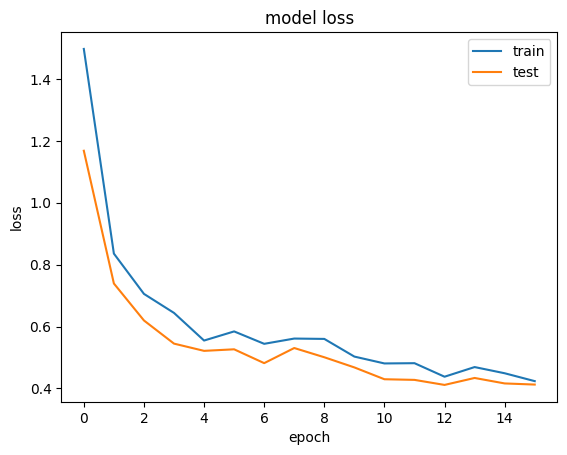

In [32]:
plot_metric(history)